In [896]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_columns = 100

import seaborn as sns
import pandas_profiling as pdp
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

from IPython.display import display
import collections
import re
import feather
import codecs

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

In [897]:
train=pd.read_csv('../input/train.csv')
test=pd.read_csv('../input/test.csv')
df_all=pd.concat([train,test],axis=0,sort=False).reset_index(drop=True)
df_all.columns=['id','rent','address','access','floor_info','old','direction','square','floor','bath','kitchen','broadcast','facility','parking','neighbors','structure','period']


train_feat1=pd.read_feather('feature1/data/train_feat1.ftr')
test_feat1=pd.read_feather('feature1/data/test_feat1.ftr')

## 目的変数外れ値・異常値の除去
RMSEは外れ値の影響を大きく受けるため

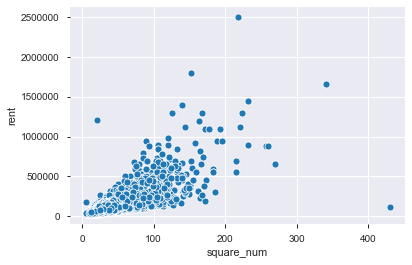

In [898]:
sns.scatterplot(train_feat1['square_num'],train_feat1['rent'])
plt.show()

In [899]:
# 外れ値、異常データを削除
train=train[train['id']!=20428][train['id']!=20232][train['id']!=20927]
train_feat1=train_feat1[train_feat1['id']!=20428][train_feat1['id']!=20232][train_feat1['id']!=20927]

index1=train_feat1.query("rent>1000000 & square_num<100").index
index2=train_feat1.query("rent>1500000").index
index3=train_feat1.query("square_num>400").index
index4=train_feat1.query('rent>100000 & square_num<10').index
drop_index=np.concatenate([index1,index2,index3,index4])

In [900]:
train_drop=train.drop(drop_index).reset_index(drop=True)
train_feat1_drop=train_feat1.drop(drop_index).reset_index(drop=True)

train_index=len(train_drop)
test_index=len(test)

df_all=pd.concat([train_drop,test],axis=0,sort=False).reset_index(drop=True)
df_all.columns=['id','rent','address','access','floor_info','old','direction','square','floor','bath','kitchen','broadcast','facility','parking','neighbors','structure','period']

df_all_feat1=pd.concat([train_feat1_drop,test_feat1],axis=0,sort=False).reset_index(drop=True)

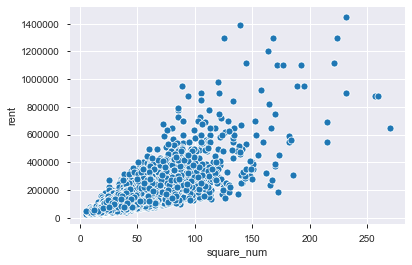

In [901]:
sns.scatterplot(train_feat1_drop['square_num'],train_feat1_drop['rent'])
plt.show()

## 間取り情報に部屋数、配置を追加

In [908]:
def add_floor_detail(df):
    # LK をDKのタイポとし、DKに変換
    df=df.replace('1LK+S(納戸)','1DK+S(納戸)')
    df=df.replace('1LK','1DK')
    floor_info=pd.read_csv('../input/floor_info.csv',encoding="utf_8")
    df_merge=pd.merge(df,floor_info,on='floor_info',how='left')
    return df_merge

In [909]:
df_all=add_floor_detail(df_all)

##  部屋総数を追加
1K=1R 1DK=1.5R  1LDK=2Rとして換算

In [910]:
def add_room_number(df):
    # ルームごとのフロア面積の平均を求める
    floor_square=pd.DataFrame()
    floor_square['floor_info']=df_all['floor_info']
    floor_square['square']=df_all_feat1['square_num']
    floor_mean=floor_square.groupby('floor_info')['square'].mean().reset_index()

    R_value=floor_mean.query("floor_info=='1R'")['square'].values
    K_value=floor_mean.query("floor_info=='1K'")['square'].values-R_value
    DK_value=floor_mean.query("floor_info=='1DK'")['square'].values-R_value
    LDK_value=floor_mean.query("floor_info=='1LDK'")['square'].values-R_value

    S_ofK_value=floor_mean.query("floor_info=='1K+S(納戸)'")['square'].values-floor_mean.query("floor_info=='1K'")['square'].values
    S_ofDK_value=floor_mean.query("floor_info=='1DK+S(納戸)'")['square'].values-floor_mean.query("floor_info=='1DK'")['square'].values
    S_ofLDK_value=floor_mean.query("floor_info=='1LDK+S(納戸)'")['square'].values-floor_mean.query("floor_info=='1LDK'")['square'].values

    # 各間取りの1Rに対する面積比を求める
    K=K_value/R_value
    DK=DK_value/R_value
    LDK=LDK_value/R_value
    S_K=S_ofK_value/R_value
    S_DK=S_ofDK_value/R_value
    S_LDK=S_ofLDK_value/R_value
    
    room_number=df['R']+df['K']*K+df['DK']*DK+df['LDK']*LDK+(df['K']>=1)*1*S_K+(df['DK']>=1)*1*S_DK+(df['LDK']>=1)*1*S_LDK
    
    df['room_number']=room_number
    return df

In [911]:
df_all=add_room_number(df_all)

## 一部屋あたりの部屋面積を追加

In [912]:
def add_square_per_room(df):
    S_per_R=df_all_feat1['square_num']/df['room_number']
    df['Square/Room']=S_per_R
    return df

In [913]:
df_all=add_square_per_room(df_all)

## 経度と緯度をメッシュで区切ってカテゴリー変数にする

In [914]:
with codecs.open("../input/13000-17.0a/13_2018.csv", "r", "Shift-JIS", "ignore") as file:
    df_cordA = pd.read_table(file, delimiter=",")
    #display(df_cordA[:3])    
with codecs.open("../input/13000-12.0b/13_2018.csv", "r", "Shift-JIS", "ignore") as file:
    df_cordB = pd.read_table(file, delimiter=",")
    #display(df_cordB[:3])
    
cordinate=df_cordA[['市区町村名','大字・丁目名','緯度','経度']]
cordinate.columns=['address_city','address_town','longitude','latitude']
cordinate.drop_duplicates(subset=['address_city','address_town'],keep='last',inplace=True)

In [915]:
def add_lat_long(df):
# 住所から区を取得
    city_tmp=df['address'].apply(lambda x:x.split('都')[1])
    df['address_city']=city_tmp.apply(lambda x:x.split('区')[0]+'区')

    # 住所から町名を取得
    town_tmp=city_tmp.apply(lambda x:x.split('区')[1])

    def town_enc(x):
        # 番地を削除
        x=re.split(r'\d+-|ー|－+\d+',x)[0]   
        # 何丁目か分かるものと、わからないもので分類
        split_list=x.split('丁目')
        if len(split_list)==2:
            return split_list[0]+'丁目'
        else:
        # 余分な数字を削除
            town=re.split(r'\d+',split_list[0])[0]
            return town

    def int2kanji(x):
        kanji_nums={'1':'一', '2':'二', '3':'三', '4':'四', '5':'五', '6':'六', '１':'一', '２':'二', '３':'三', '４':'四', '５':'五', '６':'六', '７':'七', '８':'八', '９':'九'}
        num=re.findall(r'\d+',x)
        if len(num)==0:
            return x
        else:
            return x.replace(num[0],kanji_nums[num[0]])
    df['address_town']=town_tmp.apply(lambda x:town_enc(x))
    df['address_town']=df['address_town'].apply(lambda x:int2kanji(x))
    
    df=pd.merge(df,cordinate,on=['address_city','address_town'],how='left')
    
    return df

In [916]:
df_all=add_lat_long(df_all)

In [917]:
def add_bin_latitude(df,bins):
    return pd.cut(df['latitude'],bins).astype(str)

def add_bin_longitude(df,bins):
    return pd.cut(df['longitude'],bins).astype(str)

In [918]:
df_all['cat_latitude']=add_bin_latitude(df_all,50)
df_all['cat_longitude']=add_bin_longitude(df_all,50)

In [919]:
def add_lat_long_category(df):
    df['cat_latitude'].fillna('nan',inplace=True)
    le_lat.fit(list(df['cat_latitude'].astype(str).values))
    lat_str=le_lat.transform(list(df['cat_latitude'].astype(str).values))

    le_long=LabelEncoder()
    df['cat_longitude'].fillna('nan',inplace=True)
    le_long.fit(list(df['cat_longitude'].astype(str).values))
    long_str=le_long.transform(list(df['cat_longitude'].astype(str).values))
    
    lat_long_category=[]
    for lat,long in zip(lat_str,long_str):
        lat_long_category.append(str(lat)+'_'+str(long))
        
    return lat_long_category

def mesh_encoder(df):
    mesh_le=LabelEncoder()
    mesh_le.fit(df_all['mesh_cateogry'])
    mesh_encode=le.transform(df_all['mesh_cateogry'])
    return mesh_encode

In [920]:
df_all['mesh_cateogry']=add_lat_long_category(df_all)
df_all['mesh_category_enc']=mesh_encoder(df_all)
df_all['mesh_category_enc']=df_all['mesh_category_enc'].astype('category')

## カテゴリー変数でTargetEncoding
クロスバリデーションをする際に、foldごとに作り直さないといけないので注意

In [955]:
target_cols=['floor_info','direction','direction','direction','mesh_cateogry']

def target_encode(df,target_cols):
    train_df=df[:train_index]
    test_df=df[train_index:]
    for col in target_cols:
        # 訓練データから、一時的にカテゴリー変数と目的変数のDFを作成
        data_tmp=pd.DataFrame({col:train_df[col],'target':train_df['rent']})
        # テストデータのカテゴリを訓練データの平均値で埋める
        target_mean=data_tmp.groupby(col)['target'].mean()
        test_df[col+'_target_enc']=test_df[col].map(target_mean)
        
        # 訓練データの変換後の値を格納する配列
        train_encode=np.repeat(np.nan,train_df.shape[0])
        
        kf=KFold(n_splits=4,shuffle=True,random_state=0)
        
        for idx_1,idx_2 in kf.split(train_df):
            
            # one-of-foldで各カテゴリの目的変数の平均を計算
            target_mean=data_tmp.iloc[idx_1].groupby(col)['target'].mean()
            
            # 変換後の値を一時配列に格納
            train_encode[idx_2]=train_df[col].iloc[idx_2].map(target_mean)
            
        train_df[col+'_target_enc']=train_encode
    
    return pd.concat([train_df,test_df],axis=0,sort=False).reset_index(drop=True)

In [956]:
df_all=target_encode(df_all,target_cols)

## 同じ物件がある場合は、その情報を追加

In [963]:
pd.DataFrame(df_all['address'].value_counts())

,address
東京都世田谷区太子堂２丁目,106
東京都板橋区板橋３丁目1-8,102
東京都中野区白鷺２丁目1-21,92
東京都豊島区南長崎５丁目,84
東京都中央区日本橋馬喰町２丁目4-12,81
...,...
東京都練馬区小竹町２丁目６１－６,1
東京都世田谷区桜新町１丁目40-10,1
東京都港区芝浦２丁目6-16,1
東京都練馬区石神井町２丁目8-27,1


In [981]:
def int2kanji(x):
    kanji_nums={'1':'1', '2':'2', '3':'3', '4':'4', '5':'5', '6':'6','8':'8', '１':'1', '２':'2', '３':'3', '４':'4', '５':'5', '６':'6', '７':'7', '８':'8', '９':'9'}
    num=re.findall(r'\d',x)
    if len(num)==0:
        return x
    else:
        return x.replace(num[0],kanji_nums[num[0]])

In [982]:
df_all['address'].apply(lambda x:int2kanji(x))

KeyError: '9'

In [1055]:
house_unique=df_all.groupby(['address','access','old']).size().reset_index()
tmp=house_unique[house_unique[0]!=1].sort_values(by=0,ascending=False)
pd.merge(tmp,df_all,on=['address','access','old'],how='right')

,address,access,old,0,id,rent,floor_info,direction,square,floor,bath,kitchen,broadcast,facility,parking,neighbors,structure,period,R,K,DK,LDK,S,room_number,Square/Room,address_city,address_town,longitude,latitude,cat_latitude,cat_longitude,mesh_cateogry,mesh_category_enc,floor_info_target_enc,direction_target_enc,mesh_cateogry_target_enc
0,東京都中野区白鷺２丁目1-21,西武新宿線\t鷺ノ宮駅\t徒歩8分\t\t西武新宿線\t都立家政駅\t徒歩14分\t\t西武...,0年1ヶ月,92.0,406,104500.0,1K,東,25.47m2,7階／9階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄...,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯／\t独立キッチン,インターネット対応／\tCATV／\tCSアンテナ／\tBSアンテナ／\tインターネット使用料無料,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,駐輪場\t空有\tバイク置き場\t空有\t駐車場\t無,【スーパー】 501m\t【スーパー】 924m\t【スーパー】 713m\t【コンビニ】 ...,RC（鉄筋コンクリート）,NaN,1,1,0,0,0,1.454488,17.511320,中野区,白鷺二丁目,35.722117,139.636764,"(139.636, 139.643]","(35.717, 35.723]",10_32,21,90612.474491,113657.838310,95541.666667
1,東京都中野区白鷺２丁目1-21,西武新宿線\t鷺ノ宮駅\t徒歩8分\t\t西武新宿線\t都立家政駅\t徒歩14分\t\t西武...,0年1ヶ月,92.0,1306,106000.0,1K,東,25.49m2,9階／9階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄...,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯／\t独立キッチン,インターネット対応／\tCATV／\tCSアンテナ／\tBSアンテナ／\tインターネット使用料無料,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,駐輪場\t空有\tバイク置き場\t空有\t駐車場\t無,【スーパー】 501m\t【スーパー】 924m\t【スーパー】 713m\t【コンビニ】 ...,RC（鉄筋コンクリート）,NaN,1,1,0,0,0,1.454488,17.525071,中野区,白鷺二丁目,35.722117,139.636764,"(139.636, 139.643]","(35.717, 35.723]",10_32,21,90472.527850,114592.035762,95169.696970
2,東京都中野区白鷺２丁目1-21,西武新宿線\t鷺ノ宮駅\t徒歩8分\t\t西武新宿線\t都立家政駅\t徒歩14分\t\t西武...,0年1ヶ月,92.0,2654,102000.0,1K,東,25.47m2,2階／9階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄...,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯／\t独立キッチン,インターネット対応／\tCATV／\tCSアンテナ／\tBSアンテナ／\tインターネット使用料無料,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,駐輪場\t空有\tバイク置き場\t空有\t駐車場\t無,【スーパー】 501m\t【スーパー】 924m\t【スーパー】 713m\t【コンビニ】 ...,RC（鉄筋コンクリート）,NaN,1,1,0,0,0,1.454488,17.511320,中野区,白鷺二丁目,35.722117,139.636764,"(139.636, 139.643]","(35.717, 35.723]",10_32,21,90532.156073,114251.720181,93664.406780
3,東京都中野区白鷺２丁目1-21,西武新宿線\t鷺ノ宮駅\t徒歩8分\t\t西武新宿線\t都立家政駅\t徒歩14分\t\t西武...,0年1ヶ月,92.0,2879,105500.0,1K,東,25.43m2,9階／9階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄...,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯／\t独立キッチン,インターネット対応／\tCATV／\tCSアンテナ／\tBSアンテナ／\tインターネット使用料無料,エアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t室内洗濯機置場／\t敷...,駐輪場\t空有\tバイク置き場\t空有\t駐車場\t無,【スーパー】 501m\t【スーパー】 924m\t【スーパー】 713m\t【コンビニ】 ...,RC（鉄筋コンクリート）,NaN,1,1,0,0,0,1.454488,17.483819,中野区,白鷺二丁目,35.722117,139.636764,"(139.636, 139.643]","(35.717, 35.723]",10_32,21,90612.474491,113657.838310,95541.666667
4,東京都中野区白鷺２丁目1-21,西武新宿線\t鷺ノ宮駅\t徒歩8分\t\t西武新宿線\t都立家政駅\t徒歩14分\t\t西武...,0年1ヶ月,92.0,3718,114000.0,2K,東,30.4m2,2階／9階建,専用バス／\t専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄...,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯／\t独立キッチン,インターネット対応／\tCATV／\tCSアンテナ／\tBSアンテナ／\tインターネット使用料無料,エアコン付\tウォークインクローゼット\tシューズボックス／\tバルコニー／\tフローリング...,駐輪場\t空有\tバイク置き場\t空有\t駐車場\t無,【スーパー】 501m\t【スーパー】 773m\t【コンビニ】 108m\t【コンビニ】 ...,RC（鉄筋コンクリート）,NaN,2,1,0,0,0,2.454488,12.385477,中野区,白鷺二丁目,35.722117,139.636764,"(139.636, 139.643]","(35.717, 35.723]",10_32,21,84755.709220,113657.838310,95541.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62719,東京都大田区東六郷３丁目,京急本線\t六郷土手駅\t徒歩6分\t\t京急大師線\t港町駅\t徒歩13分\t\t京急本線...,0年9ヶ月,NaN,62725,NaN,1LDK,南,37.45m2,3階／5階建,専用バス／\t専用トイレ／\tバス・トイレ別／\t追焚機能／\t浴室乾燥機\t／\t温水洗浄...,ガスコンロ／\tコンロ2口／\tシステムキッチン\t／\t給湯,インターネット対応／\t高速インターネット／\t光ファイバー／\tインターネット使用料無料,冷房／\tエアコン付\tシューズボックス／\tバルコニー／\tフローリング／\t24時間換気...,"駐車場\t近隣\t30,000円\t距離400m",【スーパー】 283m\t【スーパー】 839m\t【コンビニ】 322m\t【コンビニ】 ...,RC（鉄筋コンクリート）,NaN,1,0,0,1,0,2.726175,13.737196,大田区,東六郷三丁目,35.546462,139.714958,"(139.713, 139.72]","(35.546, 35.552]",21_1,408,157748.328841,113782.776954,113000.000000
62720,東京都中野区本町６丁目,丸ノ内線(池袋－荻窪)\t新中野駅\t徒歩4分\t\t中央線（快速）\t中野(東京都)駅\t...,2年11ヶ月,NaN,62726,NaN,1K,南,29.81m2,3階／3階建,専用トイレ／\tバス・トイレ別／\tシャワー／\t浴室乾燥機\t／\t温水洗浄便座／\t洗面台独立,コンロ設置可（コンロ2口）／\tシステムキッチン\t／\t給湯,インターネット対応／\tCSアンテナ／\tBSアンテナ／\tインターネット使用料無料,エアコン付\

In [1062]:
tmp[tmp[0]>10]

,address,access,old,0
7641,東京都中野区白鷺２丁目1-21,西武新宿線\t鷺ノ宮駅\t徒歩8分\t\t西武新宿線\t都立家政駅\t徒歩14分\t\t西武...,0年1ヶ月,92
25574,東京都板橋区板橋３丁目1-8,都営三田線\t板橋区役所前駅\t徒歩5分\t\t東武東上線\t下板橋駅\t徒歩7分\t\t都...,0年6ヶ月,89
5696,東京都中央区日本橋馬喰町２丁目4-12,総武本線\t馬喰町駅\t徒歩4分\t\t総武線・中央線（各停）\t浅草橋駅\t徒歩4分\t\...,0年3ヶ月,81
7535,東京都中野区江古田３丁目14-3,都営大江戸線\t新江古田駅\t徒歩10分\t\t西武池袋線\t江古田駅\t徒歩20分\t\t...,1年0ヶ月,75
5690,東京都中央区日本橋馬喰町２丁目,総武本線\t馬喰町駅\t徒歩4分\t\t都営浅草線\t浅草橋駅\t徒歩4分,0年3ヶ月,72
...,...,...,...,...
9265,東京都北区西ヶ原４丁目,都営三田線\t西巣鴨駅\t徒歩9分\t\t埼京線\t板橋駅\t徒歩22分\t\t山手線\t巣...,9年8ヶ月,11
29894,東京都江東区大島３丁目9-19,都営新宿線\t西大島駅\t徒歩8分\t\t都営新宿線\t大島(東京都)駅\t徒歩11分\t\...,新築,11
29146,東京都江戸川区鹿骨５丁目,総武線・中央線（各停）\t小岩駅\t徒歩29分\t\t都営新宿線\t篠崎駅\t徒歩30分\t...,0年2ヶ月,11
22415,東京都杉並区方南１丁目,京王線\t代田橋駅\t徒歩9分\t\t京王線\t笹塚駅\t徒歩12分\t\t丸ノ内線(中野坂...,0年4ヶ月,11


In [999]:
text='東京都板橋区板橋３丁目1-8'
text.translate(str.maketrans({chr(0xFF01 + i): chr(0x21 + i) for i in range(94)}))

'東京都板橋区板橋3丁目1-8'

In [1071]:
text1='東京都江戸川区鹿骨5丁目'
text2='東京都江戸川区鹿骨５丁目'

In [1073]:
text1_=text1.translate(str.maketrans({chr(0xFF01 + i): chr(0x21 + i) for i in range(94)}))
text2_=text2.translate(str.maketrans({chr(0xFF01 + i): chr(0x21 + i) for i in range(94)}))